In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neural_network import MLPRegressor

%matplotlib inline
plt.style.use('ggplot') # emulate pretty r-style plots

import gc

# Features selection & interaction

In [2]:
data1 = pd.read_csv('D:/港科/第三学期/AI in fintech/作业/project2/数据和代码/processed_data.csv')
macro_data =  pd.read_csv('D:/港科/第三学期/AI in fintech/作业/project2/数据和代码/8macro.csv')

### 1 features selection 

筛选与因变量相关系数绝对值最大的n个自变量

In [3]:
corr_matrix = data1.corr()
corr_matrix = abs(corr_matrix)

abs(相关系数)从高到低

In [4]:
corr_matrix["RET"].sort_values(ascending = False)

RET         1.000000
sp          0.025280
rd_mve      0.023341
baspread    0.023078
agr         0.020517
              ...   
70.0        0.000085
72.0        0.000058
26.0        0.000023
9.0         0.000015
53.0        0.000002
Name: RET, Length: 171, dtype: float64

In [5]:
## 去掉因变量本身、股票代码、日期之后，选相关系数绝对值排前n的变量 (n = 30)
n = 30 #保留变量个数
features_selected = corr_matrix["RET"].sort_values(ascending = False).index.drop(['RET','permno', 'DATE'])[0:n]
features_selected

Index(['sp', 'rd_mve', 'baspread', 'agr', 'ill', 'idiovol', 'dolvol', 'lev',
       'mom36m', 'invest', 'orgcap', 'egr', 'retvol', 'ps', 'hire', 'lgr',
       'chcsho', 'ep', 'rd', 'tang', 'sgr', 'grltnoa', 'gma', 'chinv', 'mom1m',
       'nincr', 'chmom', 'cashpr', 'acc', 'absacc'],
      dtype='object')

In [6]:
data2 = data1[["DATE","RET","permno"]]
data2 = data2.join(data1[features_selected])
data2.head()

,DATE,RET,permno,sp,rd_mve,baspread,agr,ill,idiovol,dolvol,...,sgr,grltnoa,gma,chinv,mom1m,nincr,chmom,cashpr,acc,absacc
0,19570329,0.018405,10006,0.0,0.0,0.013856,0.0,1.557681e-07,0.024863,10.296745,...,0.0,0.0,0.0,0.0,0.002016,0.0,0.134574,0.0,0.0,0.0
1,19570329,0.000000,10014,0.0,0.0,0.031389,0.0,8.383815e-06,0.065248,7.032404,...,0.0,0.0,0.0,0.0,-0.086957,0.0,0.006667,0.0,0.0,0.0
2,19570329,-0.003846,10022,0.0,0.0,0.010066,0.0,5.360386e-06,0.029338,7.294038,...,0.0,0.0,0.0,0.0,-0.037037,0.0,0.058761,0.0,0.0,0.0
3,19570329,0.077907,10030,0.0,0.0,0.009523,0.0,1.090908e-07,0.022007,9.516942,...,0.0,0.0,0.0,0.0,0.000000,0.0,-0.032065,0.0,0.0,0.0
4,19570329,-0.017730,10057,0.0,0.0,0.007661,0.0,2.386914e-07,0.025453,8.421013,...,0.0,0.0,0.0,0.0,-0.030717,0.0,-0.102811,0.0,0.0,0.0


### 2 interaction

循环，生成股票特征*macro的变量们，一共n*8个

In [7]:
data3 = data2
data3 = data3.reset_index(drop = True)        ## 重新设置索引
datay = data3[['RET','permno']]               ## 保留一下取样后的因变量
data3 = data3.drop(['RET','permno'], axis =1) ## 因变量等的不参与interaction

In [8]:
from tqdm import tqdm
data_tmp = data3[["DATE"]]

# 第一层：遍历data2的每一列
for i in tqdm(range(1,len(data3.columns))):
    
    # 第二层：遍历macrodata的每一列
    for j in tqdm(range(1,len(macro_data.columns))):
        
        colnames = data3.columns[i] + "*" + macro_data.columns[j]
        col_tmp = pd.DataFrame(columns = {colnames})

        # 第三层：遍历指定data2列的每一行
        for k in range(len(data3)):
            
            DATE = int(data3.iloc[k,0]/100)              #取data2日期
            macroMask = (macro_data['yyyymm'] == DATE)   #取以上日期对应的macrodata
            macro_tmp = macro_data.loc[macroMask]
            
            if len(macro_tmp) == 0:
                new_blank = None
            else:
                new_blank = macro_tmp.iloc[0,j]*data3.iloc[k,i]
            blank_tmp = pd.DataFrame([new_blank])
            blank_tmp.columns = [colnames]
            col_tmp = col_tmp.append(blank_tmp,ignore_index=True)
        
        data_tmp = data_tmp.join(col_tmp[[colnames]])

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]


 25%|█████████████████████                                                               | 2/8 [01:22<04:06, 41.11s/it]


100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [2:42:55<00:00, 325.85s/it]


In [9]:
## interation变量
data_tmp.head() 

,DATE,sp*dp,sp*ep,sp*b/m,sp*ntis,sp*tbl,sp*svar,sp*tms,sp*dfy,rd_mve*dp,...,acc*tms,acc*dfy,absacc*dp,absacc*ep,absacc*b/m,absacc*ntis,absacc*tbl,absacc*svar,absacc*tms,absacc*dfy
0,20120928,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.0,...,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
1,19730131,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.0,...,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,20000731,-1.052836,-0.780606,0.036769,0.001113,0.014077,0.000488,0.000354,0.001653,-0.0,...,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,20000428,-2.249284,-1.685223,0.076908,0.006020,0.028525,0.004002,0.003225,0.003830,-0.0,...,-0.000391,-0.000464,-0.272614,-0.204250,0.009321,0.000730,0.003457,0.000485,0.000391,0.000464
4,19910830,-2.687334,-2.373792,0.338355,0.013399,0.041208,0.001575,0.022034,0.006958,-0.0,...,0.000653,0.000206,-0.079605,-0.070317,0.010023,0.000397,0.001221,0.000047,0.000653,0.000206


In [10]:
data_tmp.to_csv('D:/港科/第三学期/AI in fintech/作业/project2/数据和代码/interaction/data_tmp.csv', index = False)

In [11]:
data3 = data3.join(data_tmp.drop(['DATE'], axis=1)) ## 把interaction变量和原有的30个特征放一起
data3 = data3.join(datay[['RET','permno']])        ## 再把因变量啥的join回来

In [12]:
data3.to_csv('D:/港科/第三学期/AI in fintech/作业/project2/数据和代码/interaction/data3.csv', index = False)

# ---------------------------------------------------------------------------------------------------------------

## Elastic net

In [2]:
data3 = pd.read_csv('D:/港科/第三学期/AI in fintech/作业/project2/数据和代码/interaction/data3.csv')

In [3]:
def GetRSqr(testY,pred):
    
    upperSum=0
    lowerSum=0
    for i in range(len(testY)):
        upperSum+=(testY[i]-pred[i])**2
        lowerSum+=(testY[i])**2
        
    return 1-(upperSum/lowerSum)

In [7]:
import numpy as np
from sklearn import linear_model
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

#存储每一个batch的r
rList=[]
combineList = []

for i in range(30):
    
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    
    trainingMask = (data3['DATE'] >= trainingMaskStart) & (data3['DATE'] < trainingMaskEnd)
    trainingData = data3.loc[trainingMask]
    
    validationMask = (data3['DATE'] >= trainingMaskEnd) & (data3['DATE'] < validationMaskEnd)
    validationData = data3.loc[validationMask]
    
    testMask = (data3['DATE'] >= validationMaskEnd) & (data3['DATE'] < testMaskEnd)
    testData = data3.loc[testMask]
    
    
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
    
    #函数：调用elasticnet来对trainingData训练并fit validationData，
    #enet调节的地方是alpha=[0.001,0.01,0.1,0.5,1]; l1_ratio=[0,0.25,0.5,0.75,1]; 这样就有25个组合要调了
    #然后我们用验证集判断R2，结果最好的那一组参数将被传入 testData 
    #testData再调用一个函数来计算R2，并存入全局变量rList中
    
    bestRSqr = float("-inf")
    bestEnet = None
    bestCombine = None
    
    for alpha in [10e-04,10e-01]:
        for l1 in [0,0.25,0.5,0.75,1]:
            enet = linear_model.ElasticNet(random_state=72, alpha = alpha, l1_ratio=l1)
            enet.fit(trainingData_x,trainingData_y)
    
            pred = enet.predict(validationData_x)
            currentRSqr = GetRSqr(validationData_y.values, pred)
            
            if(currentRSqr>bestRSqr):
                bestRSqr=currentRSqr
                bestEnet=enet
                bestCombine=(alpha,l1)
        
    resultPred = bestEnet.predict(testData_x)
    resultRSqr = GetRSqr(testData_y.values, resultPred)
    print('result R square for batch',i,': ', resultRSqr, 'best combine:', bestCombine)
    rList.append(resultRSqr)
    combineList.append(bestCombine)

result R square for batch 0 :  -0.00022839217842629544 best combine: (1.0, 0.25)
result R square for batch 1 :  0.008839562238420973 best combine: (1.0, 0.25)
result R square for batch 2 :  0.0037029890334808746 best combine: (1.0, 0.5)
result R square for batch 3 :  -0.0144130589527236 best combine: (1.0, 0.5)
result R square for batch 4 :  0.019906047024002116 best combine: (1.0, 0.5)
result R square for batch 5 :  0.009794957021153627 best combine: (1.0, 0.5)
result R square for batch 6 :  0.01525522355385256 best combine: (1.0, 0.5)
result R square for batch 7 :  -0.0238083729754357 best combine: (1.0, 0.5)
result R square for batch 8 :  0.01729383631651793 best combine: (1.0, 0.5)
result R square for batch 9 :  0.007361918250227917 best combine: (1.0, 0.5)
result R square for batch 10 :  0.016417013491961896 best combine: (1.0, 0.75)
result R square for batch 11 :  -0.00940289174157205 best combine: (1.0, 0.5)
result R square for batch 12 :  0.0015999367825251243 best combine: (0.

In [8]:
Enet_rList = rList               ##储存R²结果
Enet_combineList = combineList   ##储存参数组合
#得到30batch最终的平均r2：
print('the R squaure is: ',sum(rList) / len(rList))

the R squaure is:  0.0029882332286853995


##### feacture importance

In [54]:
var = data3.drop(['RET','permno', 'DATE'],axis = 1).columns ## data3即为跑模型用到的数据
R2_loss = pd.DataFrame(columns = {"var","r2_loss"})         ## 储存每个变量的R² loss

for j in var:    
    data_drop_1_var = data3.drop(j,axis = 1,inplace = False)
    
    i = 29
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    trainingMask = (data_drop_1_var['DATE'] >= trainingMaskStart) & (data_drop_1_var['DATE'] < trainingMaskEnd)
    trainingData = data_drop_1_var.loc[trainingMask]
    validationMask = (data_drop_1_var['DATE'] >= trainingMaskEnd) & (data_drop_1_var['DATE'] < validationMaskEnd)
    validationData = data_drop_1_var.loc[validationMask]
    testMask = (data_drop_1_var['DATE'] >= validationMaskEnd) & (data_drop_1_var['DATE'] < testMaskEnd)
    testData = data_drop_1_var.loc[testMask]
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
        
    ## ----------------------  这里要根据模型不同、参数不同修改一下  --------------------##
    # 这是之前调好的hyper parameters
    alpha = Enet_combineList[i][0]          ## 取之前存储的bestCombine
    l1 = Enet_combineList[i][1]             ## 取之前存储的bestCombine

    enet = linear_model.ElasticNet(random_state=72, alpha = alpha, l1_ratio=l1)
    enet.fit(trainingData_x,trainingData_y)
    resultPred = enet.predict(testData_x)
    ## -----------------------------------------------------------------------------------##

    resultRSqr = GetRSqr(testData_y.values, resultPred)
    RSqr_loss = Enet_rList[i] - resultRSqr    ## 计算R²减少的量，越大说明变量越重要
    blank_tmp = pd.DataFrame({'var': j, 'r2_loss': RSqr_loss},index = (0,))
    R2_loss = R2_loss.append(blank_tmp,ignore_index=True)

In [55]:
Enet_r2loss = R2_loss
Enet_r2loss.head()

,var,r2_loss
0,sp,-1.105613e-07
1,rd_mve,0.000000e+00
2,baspread,0.000000e+00
3,agr,-3.791316e-10
4,ill,0.000000e+00


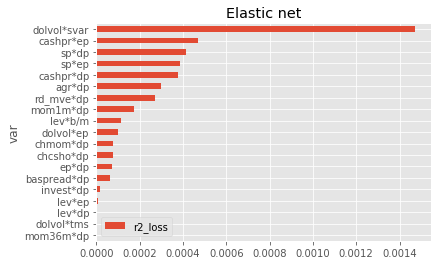

In [56]:
title = "Elastic net"
Rplot = Enet_r2loss.sort_values(by="r2_loss",axis=0,ascending=False).iloc[0:19,]
Rplot.sort_values(by="r2_loss",axis=0,ascending=True).plot(x = "var", y = "r2_loss",kind='barh',title=title)

# ---------------------------------------------------------------------------------------------------------------

# NN

## NN1: 1 hidden layer with 32 neurons

In [57]:
from sklearn.neural_network import MLPRegressor
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

#存储每一个batch的r
rList=[]
combineList = []


for i in range(30):
    
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    
    trainingMask = (data3['DATE'] >= trainingMaskStart) & (data3['DATE'] < trainingMaskEnd)
    trainingData = data3.loc[trainingMask]
    
    validationMask = (data3['DATE'] >= trainingMaskEnd) & (data3['DATE'] < validationMaskEnd)
    validationData = data3.loc[validationMask]
    
    testMask = (data3['DATE'] >= validationMaskEnd) & (data3['DATE'] < testMaskEnd)
    testData = data3.loc[testMask]
    
    
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
    
    #函数：调用MLPRegressor来对trainingData训练并fit validationData，
    #mlp调节的地方是alpha=[10e-05,10e-03]; learning_rate=[0.01,0.001]; 这样就有4个组合要调了
    #然后我们用验证集判断R2，结果最好的那一组参数将被传入 testData 
    #testData再调用一个函数来计算R2，并存入全局变量rList中
    
    bestRSqr = float("-inf")
    bestMlp = None
    bestCombine = None
    
    ## ----    NN1: 一个隐藏层，32个神经元    ----##
    hidden_layer = (32,)
    
    
    for alpha in [10e-05,10e-03]:
        for learning_rate in [0.01,0.001]:
            mlp = MLPRegressor(activation = "relu",alpha = alpha, early_stopping = True, hidden_layer_sizes = hidden_layer, batch_size = 10000, random_state = 111, solver = "adam",learning_rate_init = learning_rate)
            mlp.fit(trainingData_x,trainingData_y)
            pred = mlp.predict(validationData_x)
            currentRSqr = GetRSqr(validationData_y.values, pred)
            
            if(currentRSqr>bestRSqr):
                bestRSqr=currentRSqr
                bestMlp=mlp
                bestCombine=(alpha,learning_rate)
        
    resultPred = bestMlp.predict(testData_x)
    resultRSqr = GetRSqr(testData_y.values, resultPred)
    print('result R square for batch',i,': ', resultRSqr, 'best combine:', bestCombine)
    rList.append(resultRSqr)
    combineList.append(bestCombine)

result R square for batch 0 :  -106.77429779033149 best combine: (0.01, 0.001)
result R square for batch 1 :  -11.564904679871804 best combine: (0.01, 0.01)
result R square for batch 2 :  -9.092079671563146 best combine: (0.01, 0.01)
result R square for batch 3 :  -47.802315756388985 best combine: (0.01, 0.01)
result R square for batch 4 :  -40.12964301328392 best combine: (0.01, 0.01)
result R square for batch 5 :  -186.72534568757143 best combine: (0.01, 0.001)
result R square for batch 6 :  -119.60407220629688 best combine: (0.01, 0.01)
result R square for batch 7 :  -144.28778955642662 best combine: (0.0001, 0.01)
result R square for batch 8 :  -45.168936675631 best combine: (0.01, 0.01)
result R square for batch 9 :  -8.336819272058692 best combine: (0.01, 0.01)
result R square for batch 10 :  -55.71165846089068 best combine: (0.01, 0.01)
result R square for batch 11 :  -80.2564197633508 best combine: (0.0001, 0.01)
result R square for batch 12 :  -163.04733638460422 best combine:

In [58]:
NN1_rList = rList               ##储存R²结果
NN1_combineList = combineList   ##储存参数组合
#得到30batch最终的平均r2：
print('the R squaure is: ',sum(rList) / len(rList))

the R squaure is:  -39.99608809311603


In [59]:
var = data3.drop(['RET','permno', 'DATE'],axis = 1).columns ## data3即为跑模型用到的数据
R2_loss = pd.DataFrame(columns = {"var","r2_loss"})         ## 储存每个变量的R² loss

for j in var:    
    data_drop_1_var = data3.drop(j,axis = 1,inplace = False)
    
    i = 29
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    trainingMask = (data_drop_1_var['DATE'] >= trainingMaskStart) & (data_drop_1_var['DATE'] < trainingMaskEnd)
    trainingData = data_drop_1_var.loc[trainingMask]
    validationMask = (data_drop_1_var['DATE'] >= trainingMaskEnd) & (data_drop_1_var['DATE'] < validationMaskEnd)
    validationData = data_drop_1_var.loc[validationMask]
    testMask = (data_drop_1_var['DATE'] >= validationMaskEnd) & (data_drop_1_var['DATE'] < testMaskEnd)
    testData = data_drop_1_var.loc[testMask]
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
        
    ## ----------------------  这里要根据模型不同、参数不同修改一下  --------------------##
    hidden_layer = (32,)
    # 这是之前调好的hyper parameters
    alpha = NN1_combineList[i][0]                     ## 取之前存储的bestCombine
    learning_rate = NN1_combineList[i][1]             ## 取之前存储的bestCombine

    mlp = MLPRegressor(activation = "relu",alpha = alpha, early_stopping = True, hidden_layer_sizes = hidden_layer, batch_size = 10000, random_state = 111, solver = "adam",learning_rate_init = learning_rate)
    mlp.fit(trainingData_x,trainingData_y)
    resultPred = mlp.predict(testData_x)
    ## -----------------------------------------------------------------------------------##

    resultRSqr = GetRSqr(testData_y.values, resultPred)
    RSqr_loss = NN1_rList[i] - resultRSqr    ## 计算R²减少的量，越大说明变量越重要
    blank_tmp = pd.DataFrame({'var': j, 'r2_loss': RSqr_loss},index = (0,))
    R2_loss = R2_loss.append(blank_tmp,ignore_index=True)

In [60]:
NN1_r2loss = R2_loss
NN1_r2loss.head()

,var,r2_loss
0,sp,-0.094656
1,rd_mve,-0.415011
2,baspread,-0.458689
3,agr,0.101585
4,ill,-0.451273


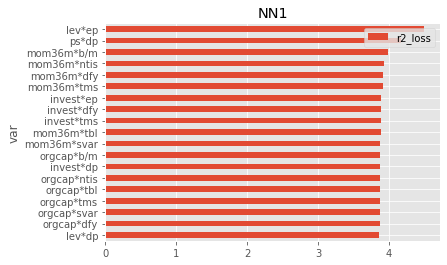

In [61]:
title = "NN1"
Rplot = NN1_r2loss.sort_values(by="r2_loss",axis=0,ascending=False).iloc[0:19,]
Rplot.sort_values(by="r2_loss",axis=0,ascending=True).plot(x = "var", y = "r2_loss",kind='barh',title=title)

## NN2: 2 hidden layers with 32 and 16 neurons, respectively

In [62]:
#存储每一个batch的r
rList=[]
combineList = []


for i in range(30):
    
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    
    trainingMask = (data3['DATE'] >= trainingMaskStart) & (data3['DATE'] < trainingMaskEnd)
    trainingData = data3.loc[trainingMask]
    
    validationMask = (data3['DATE'] >= trainingMaskEnd) & (data3['DATE'] < validationMaskEnd)
    validationData = data3.loc[validationMask]
    
    testMask = (data3['DATE'] >= validationMaskEnd) & (data3['DATE'] < testMaskEnd)
    testData = data3.loc[testMask]
    
    
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
    
    #函数：调用MLPRegressor来对trainingData训练并fit validationData，
    #mlp调节的地方是alpha=[10e-05,10e-03]; learning_rate=[0.01,0.001]; 这样就有4个组合要调了
    #然后我们用验证集判断R2，结果最好的那一组参数将被传入 testData 
    #testData再调用一个函数来计算R2，并存入全局变量rList中
    
    bestRSqr = float("-inf")
    bestMlp = None
    bestCombine = None
    
    ## ----    NN2: 2个隐藏层，分别是32、16个神经元    ----##
    hidden_layer = (32,16)
    
    
    for alpha in [10e-05,10e-03]:
        for learning_rate in [0.01,0.001]:
            mlp = MLPRegressor(activation = "relu",alpha = alpha, early_stopping = True, hidden_layer_sizes = hidden_layer,  max_iter = 500, batch_size = 10000,random_state = 111, solver = "adam",learning_rate_init = learning_rate)
            mlp.fit(trainingData_x,trainingData_y)
            pred = mlp.predict(validationData_x)
            currentRSqr = GetRSqr(validationData_y.values, pred)
            
            if(currentRSqr>bestRSqr):
                bestRSqr=currentRSqr
                bestMlp=mlp
                bestCombine=(alpha,learning_rate)
        
    resultPred = bestMlp.predict(testData_x)
    resultRSqr = GetRSqr(testData_y.values, resultPred)
    print('result R square for batch',i,': ', resultRSqr, 'best combine:', bestCombine)
    rList.append(resultRSqr)
    combineList.append(bestCombine)

result R square for batch 0 :  -1.3067955704211607 best combine: (0.01, 0.01)
result R square for batch 1 :  -28.85173636528188 best combine: (0.01, 0.001)
result R square for batch 2 :  -7.153480644743889 best combine: (0.01, 0.01)
result R square for batch 3 :  -5.471676260679948 best combine: (0.0001, 0.01)
result R square for batch 4 :  -136.73345208694417 best combine: (0.01, 0.001)
result R square for batch 5 :  -95.49059633865532 best combine: (0.01, 0.01)
result R square for batch 6 :  -140.49965146171087 best combine: (0.0001, 0.001)
result R square for batch 7 :  -110.15565355035184 best combine: (0.01, 0.01)
result R square for batch 8 :  -6.084748764986299 best combine: (0.0001, 0.01)
result R square for batch 9 :  -5.05981897595789 best combine: (0.01, 0.01)
result R square for batch 10 :  -3.3173340851635844 best combine: (0.01, 0.01)
result R square for batch 11 :  -3.4313193074172927 best combine: (0.0001, 0.01)
result R square for batch 12 :  -6.896955639918608 best co

In [63]:
NN2_rList = rList               ##储存R²结果
NN2_combineList = combineList   ##储存参数组合
#得到30batch最终的平均r2：
print('the R squaure is: ',sum(rList) / len(rList))

the R squaure is:  -19.37338450769564


In [64]:
var = data3.drop(['RET','permno', 'DATE'],axis = 1).columns ## data3即为跑模型用到的数据
R2_loss = pd.DataFrame(columns = {"var","r2_loss"})         ## 储存每个变量的R² loss

for j in var:    
    data_drop_1_var = data3.drop(j,axis = 1,inplace = False)
    
    i = 29
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    trainingMask = (data_drop_1_var['DATE'] >= trainingMaskStart) & (data_drop_1_var['DATE'] < trainingMaskEnd)
    trainingData = data_drop_1_var.loc[trainingMask]
    validationMask = (data_drop_1_var['DATE'] >= trainingMaskEnd) & (data_drop_1_var['DATE'] < validationMaskEnd)
    validationData = data_drop_1_var.loc[validationMask]
    testMask = (data_drop_1_var['DATE'] >= validationMaskEnd) & (data_drop_1_var['DATE'] < testMaskEnd)
    testData = data_drop_1_var.loc[testMask]
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
        
    ## ----------------------  这里要根据模型不同、参数不同修改一下  --------------------##
    hidden_layer = (32,16)
    # 这是之前调好的hyper parameters
    alpha = NN2_combineList[i][0]                     ## 取之前存储的bestCombine
    learning_rate = NN2_combineList[i][1]             ## 取之前存储的bestCombine

    mlp = MLPRegressor(activation = "relu",alpha = alpha, early_stopping = True, hidden_layer_sizes = hidden_layer, batch_size = 10000, random_state = 111, solver = "adam",learning_rate_init = learning_rate)
    mlp.fit(trainingData_x,trainingData_y)
    resultPred = mlp.predict(testData_x)
    ## -----------------------------------------------------------------------------------##

    resultRSqr = GetRSqr(testData_y.values, resultPred)
    RSqr_loss = NN2_rList[i] - resultRSqr    ## 计算R²减少的量，越大说明变量越重要
    blank_tmp = pd.DataFrame({'var': j, 'r2_loss': RSqr_loss},index = (0,))
    R2_loss = R2_loss.append(blank_tmp,ignore_index=True)

In [65]:
NN2_r2loss = R2_loss
NN2_r2loss.head()

,var,r2_loss
0,sp,0.816000
1,rd_mve,1.145894
2,baspread,1.180953
3,agr,0.732317
4,ill,0.580540


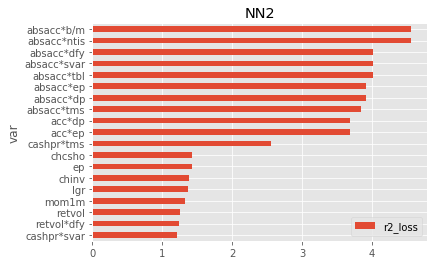

In [66]:
title = "NN2"
Rplot = NN2_r2loss.sort_values(by="r2_loss",axis=0,ascending=False).iloc[0:19,]
Rplot.sort_values(by="r2_loss",axis=0,ascending=True).plot(x = "var", y = "r2_loss",kind='barh',title=title)

## NN3: 3 hidden layers with 32 ,16 and 8 neurons, respectively

In [67]:
#存储每一个batch的r
rList=[]
combineList = []


for i in range(30):
    
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    
    trainingMask = (data3['DATE'] >= trainingMaskStart) & (data3['DATE'] < trainingMaskEnd)
    trainingData = data3.loc[trainingMask]
    
    validationMask = (data3['DATE'] >= trainingMaskEnd) & (data3['DATE'] < validationMaskEnd)
    validationData = data3.loc[validationMask]
    
    testMask = (data3['DATE'] >= validationMaskEnd) & (data3['DATE'] < testMaskEnd)
    testData = data3.loc[testMask]
    
    
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
    
    #函数：调用MLPRegressor来对trainingData训练并fit validationData，
    #mlp调节的地方是alpha=[10e-05,10e-03]; learning_rate=[0.01,0.001]; 这样就有4个组合要调了
    #然后我们用验证集判断R2，结果最好的那一组参数将被传入 testData 
    #testData再调用一个函数来计算R2，并存入全局变量rList中
    
    bestRSqr = float("-inf")
    bestMlp = None
    bestCombine = None
    
    ## ----    NN3: 3个隐藏层，分别是32、16、8个神经元    ----##
    hidden_layer = (32,16,8)
    
    
    for alpha in [10e-05,10e-03]:
        for learning_rate in [0.01,0.001]:
            mlp = MLPRegressor(activation = "relu",alpha = alpha, early_stopping = True, hidden_layer_sizes = hidden_layer,  max_iter = 500, batch_size = 10000,random_state = 111, solver = "adam",learning_rate_init = learning_rate)
            mlp.fit(trainingData_x,trainingData_y)
            pred = mlp.predict(validationData_x)
            currentRSqr = GetRSqr(validationData_y.values, pred)
            
            if(currentRSqr>bestRSqr):
                bestRSqr=currentRSqr
                bestMlp=mlp
                bestCombine=(alpha,learning_rate)
        
    resultPred = bestMlp.predict(testData_x)
    resultRSqr = GetRSqr(testData_y.values, resultPred)
    print('result R square for batch',i,': ', resultRSqr, 'best combine:', bestCombine)
    rList.append(resultRSqr)
    combineList.append(bestCombine)

result R square for batch 0 :  -0.2367349550020954 best combine: (0.01, 0.01)
result R square for batch 1 :  -0.24879063730935824 best combine: (0.0001, 0.01)
result R square for batch 2 :  -0.27177462129144425 best combine: (0.0001, 0.01)
result R square for batch 3 :  -0.2358652599058546 best combine: (0.0001, 0.01)
result R square for batch 4 :  -0.06579107900263792 best combine: (0.01, 0.01)
result R square for batch 5 :  -1.1759210198957848 best combine: (0.01, 0.01)
result R square for batch 6 :  -10.36522777781354 best combine: (0.0001, 0.01)
result R square for batch 7 :  -4.15144907526603 best combine: (0.0001, 0.01)
result R square for batch 8 :  -0.5482496772847578 best combine: (0.0001, 0.01)
result R square for batch 9 :  -1.009583026832742 best combine: (0.0001, 0.01)
result R square for batch 10 :  -0.23891972182032006 best combine: (0.01, 0.01)
result R square for batch 11 :  -11.465048543029775 best combine: (0.01, 0.01)
result R square for batch 12 :  -3.1415872583799

In [68]:
NN3_rList = rList               ##储存R²结果
NN3_combineList = combineList   ##储存参数组合
#得到30batch最终的平均r2：
print('the R squaure is: ',sum(rList) / len(rList))

the R squaure is:  -1.3810557201871176


In [69]:
var = data3.drop(['RET','permno', 'DATE'],axis = 1).columns ## data3即为跑模型用到的数据
R2_loss = pd.DataFrame(columns = {"var","r2_loss"})         ## 储存每个变量的R² loss

for j in var:    
    data_drop_1_var = data3.drop(j,axis = 1,inplace = False)
    
    i = 29
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    trainingMask = (data_drop_1_var['DATE'] >= trainingMaskStart) & (data_drop_1_var['DATE'] < trainingMaskEnd)
    trainingData = data_drop_1_var.loc[trainingMask]
    validationMask = (data_drop_1_var['DATE'] >= trainingMaskEnd) & (data_drop_1_var['DATE'] < validationMaskEnd)
    validationData = data_drop_1_var.loc[validationMask]
    testMask = (data_drop_1_var['DATE'] >= validationMaskEnd) & (data_drop_1_var['DATE'] < testMaskEnd)
    testData = data_drop_1_var.loc[testMask]
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
        
    ## ----------------------  这里要根据模型不同、参数不同修改一下  --------------------##
    hidden_layer = (32,16,8)
    # 这是之前调好的hyper parameters
    alpha = NN3_combineList[i][0]                     ## 取之前存储的bestCombine
    learning_rate = NN3_combineList[i][1]             ## 取之前存储的bestCombine

    mlp = MLPRegressor(activation = "relu",alpha = alpha, early_stopping = True, hidden_layer_sizes = hidden_layer, batch_size = 10000, random_state = 111, solver = "adam",learning_rate_init = learning_rate)
    mlp.fit(trainingData_x,trainingData_y)
    resultPred = mlp.predict(testData_x)
    ## -----------------------------------------------------------------------------------##

    resultRSqr = GetRSqr(testData_y.values, resultPred)
    RSqr_loss = NN3_rList[i] - resultRSqr    ## 计算R²减少的量，越大说明变量越重要
    blank_tmp = pd.DataFrame({'var': j, 'r2_loss': RSqr_loss},index = (0,))
    R2_loss = R2_loss.append(blank_tmp,ignore_index=True)

In [70]:
NN3_r2loss = R2_loss
NN3_r2loss.head()

,var,r2_loss
0,sp,-0.011175
1,rd_mve,-0.012539
2,baspread,-0.044730
3,agr,0.007544
4,ill,-0.031761


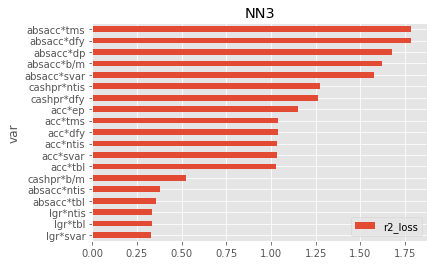

In [71]:
title = "NN3"
Rplot = NN3_r2loss.sort_values(by="r2_loss",axis=0,ascending=False).iloc[0:19,]
Rplot.sort_values(by="r2_loss",axis=0,ascending=True).plot(x = "var", y = "r2_loss",kind='barh',title=title)

## NN4: 4 hidden layers with 32 ,16 ,8 and 4 neurons, respectively

In [72]:
#存储每一个batch的r
rList=[]
combineList = []


for i in range(30):
    
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    
    trainingMask = (data3['DATE'] >= trainingMaskStart) & (data3['DATE'] < trainingMaskEnd)
    trainingData = data3.loc[trainingMask]
    
    validationMask = (data3['DATE'] >= trainingMaskEnd) & (data3['DATE'] < validationMaskEnd)
    validationData = data3.loc[validationMask]
    
    testMask = (data3['DATE'] >= validationMaskEnd) & (data3['DATE'] < testMaskEnd)
    testData = data3.loc[testMask]
    
    
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
    
    #函数：调用MLPRegressor来对trainingData训练并fit validationData，
    #mlp调节的地方是alpha=[10e-05,10e-03]; learning_rate=[0.01,0.001]; 这样就有4个组合要调了
    #然后我们用验证集判断R2，结果最好的那一组参数将被传入 testData 
    #testData再调用一个函数来计算R2，并存入全局变量rList中
    
    bestRSqr = float("-inf")
    bestMlp = None
    bestCombine = None
    
    ## ----    NN4: 4个隐藏层，分别是32、16、8、4个神经元    ----##
    hidden_layer = (32,16,8,4)
    
    
    for alpha in [10e-05,10e-03]:
        for learning_rate in [0.01,0.001]:
            mlp = MLPRegressor(activation = "relu",alpha = alpha, early_stopping = True, hidden_layer_sizes = hidden_layer,  max_iter = 500, batch_size = 10000,random_state = 111, solver = "adam",learning_rate_init = learning_rate)
            mlp.fit(trainingData_x,trainingData_y)
            pred = mlp.predict(validationData_x)
            currentRSqr = GetRSqr(validationData_y.values, pred)
            
            if(currentRSqr>bestRSqr):
                bestRSqr=currentRSqr
                bestMlp=mlp
                bestCombine=(alpha,learning_rate)
        
    resultPred = bestMlp.predict(testData_x)
    resultRSqr = GetRSqr(testData_y.values, resultPred)
    print('result R square for batch',i,': ', resultRSqr, 'best combine:', bestCombine)
    rList.append(resultRSqr)
    combineList.append(bestCombine)

result R square for batch 0 :  -0.7684928879148547 best combine: (0.0001, 0.01)
result R square for batch 1 :  -0.8323064187099773 best combine: (0.01, 0.01)
result R square for batch 2 :  -0.6316908442557347 best combine: (0.0001, 0.01)
result R square for batch 3 :  -0.8635350070928272 best combine: (0.0001, 0.01)
result R square for batch 4 :  -0.1994110119624064 best combine: (0.0001, 0.01)
result R square for batch 5 :  -0.20242655915981667 best combine: (0.0001, 0.01)
result R square for batch 6 :  -1.3093983272997671 best combine: (0.0001, 0.01)
result R square for batch 7 :  -1.606027283782009 best combine: (0.01, 0.01)
result R square for batch 8 :  -0.5027678051387752 best combine: (0.0001, 0.01)
result R square for batch 9 :  -0.9228007094492483 best combine: (0.0001, 0.01)
result R square for batch 10 :  -0.620107674687632 best combine: (0.01, 0.01)
result R square for batch 11 :  -1.0659764765686002 best combine: (0.0001, 0.01)
result R square for batch 12 :  -0.9864616797

In [73]:
NN4_rList = rList               ##储存R²结果
NN4_combineList = combineList   ##储存参数组合
#得到30batch最终的平均r2：
print('the R squaure is: ',sum(rList) / len(rList))

the R squaure is:  -0.8329372612049901


In [74]:
var = data3.drop(['RET','permno', 'DATE'],axis = 1).columns ## data3即为跑模型用到的数据
R2_loss = pd.DataFrame(columns = {"var","r2_loss"})         ## 储存每个变量的R² loss

for j in var:    
    data_drop_1_var = data3.drop(j,axis = 1,inplace = False)
    
    i = 29
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    trainingMask = (data_drop_1_var['DATE'] >= trainingMaskStart) & (data_drop_1_var['DATE'] < trainingMaskEnd)
    trainingData = data_drop_1_var.loc[trainingMask]
    validationMask = (data_drop_1_var['DATE'] >= trainingMaskEnd) & (data_drop_1_var['DATE'] < validationMaskEnd)
    validationData = data_drop_1_var.loc[validationMask]
    testMask = (data_drop_1_var['DATE'] >= validationMaskEnd) & (data_drop_1_var['DATE'] < testMaskEnd)
    testData = data_drop_1_var.loc[testMask]
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
        
    ## ----------------------  这里要根据模型不同、参数不同修改一下  --------------------##
    hidden_layer = (32,16,8,4)
    # 这是之前调好的hyper parameters
    alpha = NN4_combineList[i][0]                     ## 取之前存储的bestCombine
    learning_rate = NN4_combineList[i][1]             ## 取之前存储的bestCombine

    mlp = MLPRegressor(activation = "relu",alpha = alpha, early_stopping = True, hidden_layer_sizes = hidden_layer, batch_size = 10000, random_state = 111, solver = "adam",learning_rate_init = learning_rate)
    mlp.fit(trainingData_x,trainingData_y)
    resultPred = mlp.predict(testData_x)
    ## -----------------------------------------------------------------------------------##

    resultRSqr = GetRSqr(testData_y.values, resultPred)
    RSqr_loss = NN4_rList[i] - resultRSqr    ## 计算R²减少的量，越大说明变量越重要
    blank_tmp = pd.DataFrame({'var': j, 'r2_loss': RSqr_loss},index = (0,))
    R2_loss = R2_loss.append(blank_tmp,ignore_index=True)

In [75]:
NN4_r2loss = R2_loss
NN4_r2loss.head()

,var,r2_loss
0,sp,-0.333621
1,rd_mve,-0.365458
2,baspread,-0.355114
3,agr,-0.332268
4,ill,-0.353488


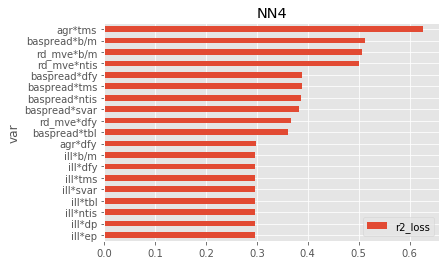

In [76]:
title = "NN4"
Rplot = NN4_r2loss.sort_values(by="r2_loss",axis=0,ascending=False).iloc[0:19,]
Rplot.sort_values(by="r2_loss",axis=0,ascending=True).plot(x = "var", y = "r2_loss",kind='barh',title=title)

## NN5: 5 hidden layers with 32 ,16 ,8 , 4 and 2 neurons, respectively

In [77]:
#存储每一个batch的r
rList=[]
combineList = []


for i in range(30):
    
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    
    trainingMask = (data3['DATE'] >= trainingMaskStart) & (data3['DATE'] < trainingMaskEnd)
    trainingData = data3.loc[trainingMask]
    
    validationMask = (data3['DATE'] >= trainingMaskEnd) & (data3['DATE'] < validationMaskEnd)
    validationData = data3.loc[validationMask]
    
    testMask = (data3['DATE'] >= validationMaskEnd) & (data3['DATE'] < testMaskEnd)
    testData = data3.loc[testMask]
    
    
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
    
    #函数：调用MLPRegressor来对trainingData训练并fit validationData，
    #mlp调节的地方是alpha=[10e-05,10e-03]; learning_rate=[0.01,0.001]; 这样就有4个组合要调了
    #然后我们用验证集判断R2，结果最好的那一组参数将被传入 testData 
    #testData再调用一个函数来计算R2，并存入全局变量rList中
    
    bestRSqr = float("-inf")
    bestMlp = None
    bestCombine = None
    
    ## ----    NN5: 5个隐藏层，分别是32、16、8、4、2个神经元    ----##
    hidden_layer = (32,16,8,4,2)
    
    
    for alpha in [10e-05,10e-03]:
        for learning_rate in [0.01,0.001]:
            mlp = MLPRegressor(activation = "relu",alpha = alpha, early_stopping = True, hidden_layer_sizes = hidden_layer,  max_iter = 500, batch_size = 10000,random_state = 111, solver = "adam",learning_rate_init = learning_rate)
            mlp.fit(trainingData_x,trainingData_y)
            pred = mlp.predict(validationData_x)
            currentRSqr = GetRSqr(validationData_y.values, pred)
            
            if(currentRSqr>bestRSqr):
                bestRSqr=currentRSqr
                bestMlp=mlp
                bestCombine=(alpha,learning_rate)
        
    resultPred = bestMlp.predict(testData_x)
    resultRSqr = GetRSqr(testData_y.values, resultPred)
    print('result R square for batch',i,': ', resultRSqr, 'best combine:', bestCombine)
    rList.append(resultRSqr)
    combineList.append(bestCombine)

result R square for batch 0 :  8.128564751153089e-05 best combine: (0.0001, 0.01)
result R square for batch 1 :  -0.021582828801674392 best combine: (0.0001, 0.01)
result R square for batch 2 :  0.0032534063778490996 best combine: (0.0001, 0.01)
result R square for batch 3 :  -0.004309620348445176 best combine: (0.0001, 0.01)
result R square for batch 4 :  0.00946697164225474 best combine: (0.0001, 0.01)
result R square for batch 5 :  0.00747958069968091 best combine: (0.01, 0.01)
result R square for batch 6 :  0.012918597789975617 best combine: (0.0001, 0.01)
result R square for batch 7 :  -0.01146610971751083 best combine: (0.0001, 0.01)
result R square for batch 8 :  0.013759400544613665 best combine: (0.0001, 0.01)
result R square for batch 9 :  0.007313843225085881 best combine: (0.0001, 0.01)
result R square for batch 10 :  0.008541585250900208 best combine: (0.0001, 0.01)
result R square for batch 11 :  -0.0025459076954825743 best combine: (0.01, 0.01)
result R square for batch 

In [78]:
NN5_rList = rList               ##储存R²结果
NN5_combineList = combineList   ##储存参数组合
#得到30batch最终的平均r2：
print('the R squaure is: ',sum(rList) / len(rList))

the R squaure is:  0.0035296307930301586


In [6]:
var = data3.drop(['RET','permno', 'DATE'],axis = 1).columns ## data3即为跑模型用到的数据
R2_loss = pd.DataFrame(columns = {"var","r2_loss"})         ## 储存每个变量的R² loss

for j in var:    
    data_drop_1_var = data3.drop(j,axis = 1,inplace = False)
    
    i = 29
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    trainingMask = (data_drop_1_var['DATE'] >= trainingMaskStart) & (data_drop_1_var['DATE'] < trainingMaskEnd)
    trainingData = data_drop_1_var.loc[trainingMask]
    validationMask = (data_drop_1_var['DATE'] >= trainingMaskEnd) & (data_drop_1_var['DATE'] < validationMaskEnd)
    validationData = data_drop_1_var.loc[validationMask]
    testMask = (data_drop_1_var['DATE'] >= validationMaskEnd) & (data_drop_1_var['DATE'] < testMaskEnd)
    testData = data_drop_1_var.loc[testMask]
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
        
    ## ----------------------  这里要根据模型不同、参数不同修改一下  --------------------##
    hidden_layer = (32,16,8,4,2)
    # 这是之前调好的hyper parameters
    alpha = NN5_combineList[i][0]                     ## 取之前存储的bestCombine
    learning_rate = NN5_combineList[i][1]             ## 取之前存储的bestCombine

    mlp = MLPRegressor(activation = "relu",alpha = alpha, early_stopping = True, hidden_layer_sizes = hidden_layer, batch_size = 10000, random_state = 111, solver = "adam",learning_rate_init = learning_rate)
    mlp.fit(trainingData_x,trainingData_y)
    resultPred = mlp.predict(testData_x)
    ## -----------------------------------------------------------------------------------##

    resultRSqr = GetRSqr(testData_y.values, resultPred)
    RSqr_loss = NN5_rList[i] - resultRSqr    ## 计算R²减少的量，越大说明变量越重要
    blank_tmp = pd.DataFrame({'var': j, 'r2_loss': RSqr_loss},index = (0,))
    R2_loss = R2_loss.append(blank_tmp,ignore_index=True)

In [7]:
NN5_r2loss = R2_loss
NN5_r2loss.head()

,var,r2_loss
0,sp,0.000571
1,rd_mve,0.000573
2,baspread,0.000572
3,agr,0.000572
4,ill,0.000571


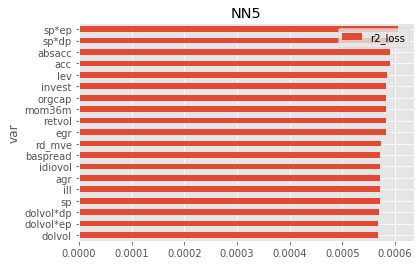

In [8]:
title = "NN5"
Rplot = NN5_r2loss.sort_values(by="r2_loss",axis=0,ascending=False).iloc[0:19,]
Rplot.sort_values(by="r2_loss",axis=0,ascending=True).plot(x = "var", y = "r2_loss",kind='barh',title=title)